In [5]:
from collections import Counter
from typing import Self

from common import SiteBasis

import picos as pc
import numpy as np
from scipy.sparse import csr_array, coo_array, block_array
from sympy.matrices import Matrix
import matplotlib.pyplot as plt
from collections import Counter
from bitarray import bitarray
from bitarray.util import count_and

In [6]:
# An efficient implementation of Pauli string operations (arXiV:2405.19287)
# z is bits [0, 2, 4, ...], x is bits [1, 3, 5, ...]

class PauliString:
    CODEC = {'I': bitarray('00'),
             'Z': bitarray('10'),
             'X': bitarray('01'),
             'Y': bitarray('11'),}
    def __init__(self, label: str | Self = None, bits: bitarray = None):
        self.bits = None
        if not ((label is None) ^ (bits is None)):
            raise ValueError("exactly one of label or bits must be provided")
        if bits is None:
            if isinstance(label, str):
                self.bits = bitarray()
                self.bits.encode(self.CODEC, label)
            elif isinstance(label, PauliString):
                self.bits = label.bits.copy()
            else:
                raise TypeError(f"Unsupported type {type(label)}")
        else:
            if isinstance(bits, bitarray):
                self.bits = bits.copy()
            else:
                raise TypeError(f"Unsupported type {type(bits)}")
    
    def __hash__(self):
        return hash(str(self.bits))

    def __repr__(self):
        return ''.join(self.bits.decode(self.CODEC))
    
    def __eq__(self, other):
        """Equality of two PauliStrings."""
        if not isinstance(other, PauliString):
            raise TypeError("other is not a PauliString")
        return self.bits == other.bits

    def __mul__(self, other: Self):
        """Multiply two PauliStrings."""
        if not isinstance(other, PauliString):
            raise TypeError("other is not a PauliString")
        return self.multiply(other)

    def __or__(self, other: Self):
        """Commutator of two PauliStrings."""
        if not isinstance(other, PauliString):
            raise TypeError("other is not a PauliString")
        return self.multiply(other) if not self.commutes_with(other) else None
    
    def __and__(self, other: Self):
        """Anticommutator of two PauliStrings."""
        if not isinstance(other, PauliString):
            raise TypeError("other is not a PauliString")
        return self.multiply(other) if self.commutes_with(other) else None
    
    def commutes_with(self, other: Self):
        """Check if two Pauli bitarrays commute."""
        if not isinstance(other, PauliString):
            raise TypeError("other is not a PauliString")
        return count_and(self.bits[::2], other.bits[1::2]) % 2 == count_and(self.bits[1::2], other.bits[::2]) % 2
    
    def phase(self, other: Self):
        """Find the phase of the product of two Pauli bitarrays."""
        if not isinstance(other, PauliString):
            raise TypeError("other is not a PauliString")
        return (-1j) ** ((2 * count_and(self.bits[1::2], other.bits[::2])
                          + count_and(self.bits[::2], self.bits[1::2])
                          + count_and(other.bits[::2], other.bits[1::2])
                          - count_and(self.bits[::2] ^ other.bits[::2], self.bits[1::2] ^ other.bits[1::2])) % 4)
    
    def multiply(self, other: Self):
        """Return the Pauli bitarray corresponding to the product of two Pauli bitarrays."""
        if not isinstance(other, PauliString):
            raise TypeError("other is not a PauliString")
        return PauliString(bits=self.bits ^ other.bits)

class PauliSum:
    # Consider implementing __iter__
    def __init__(self, labels_and_weights: dict[str, complex] | str | PauliString | Self):
        self.terms = None
        if isinstance(labels_and_weights, dict):
            self.terms = self.clean(Counter({PauliString(label): weight for label, weight in labels_and_weights.items()}))
        elif isinstance(labels_and_weights, str):
            self.terms = Counter({PauliString(labels_and_weights): 1.0})
        elif isinstance(labels_and_weights, PauliString):
            self.terms = Counter({PauliString(bits=labels_and_weights.bits): 1.0})
        elif isinstance(labels_and_weights, PauliSum):
            self.terms = labels_and_weights.terms.copy()
        else:
            raise TypeError(f"Unsupported type {type(labels_and_weights)}")
    
    def __hash__(self):
        raise NotImplementedError
    
    def __repr__(self):
        if self.is_zero():
            return f'{0j:.2f}'
        return '; '.join(f'{weight:.2f}*{string}' for string, weight in self.terms.items())
    
    def __iadd__(self, other: Self):
        if not isinstance(other, PauliSum):
            raise TypeError("other is not a PauliSum")
        for pstr, weight in other.terms.items():
            self.terms[pstr] += weight
            if np.isclose(np.abs(self.terms[pstr]), 0):
                del self.terms[pstr]
        return self
    
    def __add__(self, other: Self):
        res = PauliSum(self)
        res += other
        return res

    def __imul__(self, other: complex):
        if not isinstance(other, complex):
            raise TypeError("other is not a complex")
        for pstr in self.terms:
            self.terms[pstr] *= other
        return self

    def __rmul__(self, other: complex):
        if not isinstance(other, complex):
            raise TypeError("other is not a complex")
        res = PauliSum(self)
        res *= other
        return res

    def __mul__(self, other: Self | complex):
        """Multiply two PauliSums."""
        if isinstance(other, PauliSum):
            res = Counter()
            for l1, w1 in self.terms.items():
                for l2, w2 in other.terms.items():
                    res[l1 * l2] += l1.phase(l2) * w1 * w2
            return PauliSum(res)
        elif isinstance(other, complex):
            res = PauliSum(self)
            res *= other
            return res
        raise TypeError(f"Unsupported type {type(other)}")

    def __or__(self, other: Self):
        """Commutator of two PauliSums."""
        if not isinstance(other, PauliSum):
            raise TypeError("other is not a PauliSum")
        res = Counter()
        for l1, w1 in self.terms.items():
            for l2, w2 in other.terms.items():
                if not l1.commutes_with(l2):
                    res[l1 * l2] += 2 * l1.phase(l2) * w1 * w2
        return PauliSum(res)

    def __and__(self, other: Self):
        """Anticommutator of two PauliSums."""
        if not isinstance(other, PauliSum):
            raise TypeError("other is not a PauliSum")
        res = Counter()
        for l1, w1 in self.terms.items():
            for l2, w2 in other.terms.items():
                if l1.commutes_with(l2):
                    res[l1 * l2] += 2 * l1.phase(l2) * w1 * w2
        return PauliSum(res)
    
    def is_zero(self):
        return not self.terms

    def clean(self, dirty_counter: Counter):
        """Remove zero terms."""
        return Counter({label: weight for label, weight in dirty_counter.items() if not np.isclose(np.abs(weight), 0)})

<h2>Directly in QICS:</h2>

In [8]:
class BasisReduction():
    def __init__(self, A, b, basis):
        self._basis = basis
        self._A = A.copy()
        self._b = b.copy()
        # Row reduced echelon form of A | b system
        self._Arref, self._brref = Matrix(A).rref_rhs(Matrix(b))
        self._pivots = Matrix(A).rref()[1]
        self._free = sorted(list(set(range(A.shape[1])) - set(self._pivots))) # This is with the original numbering
        self._original_to_free_map = {original: free for free, original in enumerate(self._free)}
        self._sz = len(self._free)
        self._reductions = [[PauliSum({}), 0.0] for _ in range(basis.size())]
        self._init_free() # Initialize mappings for free variables
        self._generate_reductions() # Initialize mappings for pivot variables

    def _init_free(self):
        for i, p in enumerate(self._free):
            self._reductions[p][0] = PauliSum(self._basis.unrank(i))
            self._reductions[p][1] = np.complex128(0.0)
    
    def _generate_reductions(self):
        crow = len(self._pivots) - 1
        for pcol in reversed(self._pivots):
            # Create mapping
            self._reductions[pcol][1] += np.double(self._brref[crow])
            for ccol in range(pcol + 1, self._A.shape[1]):
                if not np.isclose(np.abs(self._Arref[crow, ccol]), 0.0):
                    coeff = -complex(self._Arref[crow, ccol]) # minus sign to transfer to other side of equality
                    self._reductions[pcol][0] += coeff * self._reductions[ccol][0]
                    self._reductions[pcol][1] += coeff * self._reductions[ccol][1]
            # Update crow
            crow -= 1

    def size(self):
        return self._sz
    
    def rank(self, elem: str):
        # Return the index of an element of the reduced basis
        return self._original_to_free_map[self._basis.rank(elem)]

    def reduce(self, elem: str):
        # Return a mapping of an element of the original basis
        # to a linear combination + constant offset of the new basis
        return self._reductions[self._basis.rank(elem)]
    
    def reduce_pauli_sum(self, op: PauliSum):
        red = [PauliSum({}), np.complex128(0.0)]
        for pstr, weight in op.terms.items():
            reduced = self.reduce(str(pstr))
            red[0] += weight * reduced[0]
            red[1] += weight * reduced[1]
        return red

In [ ]:
def schwinger_dyson(hamil: PauliSum, word1: str) -> PauliSum:
    return hamil | PauliSum(word1)

def get_A_term(basis, i, j):
    ops1 = basis.unrank(i)
    ops2 = basis.unrank(j)
    coeff, word = product(ops1, ops2)
    return coeff, basis.rank(word)

def get_B_term(basis, i, j):
    ops1 = basis.unrank(i)
    ops2 = basis.unrank(j)
    coeff, word = product(ops2, ops1)
    return coeff, basis.rank(word)

def get_C_term(basis, i, j, hamil):
    ops1 = basis.unrank(i)
    ops2 = basis.unrank(j)
    termsd = Counter()
    for coeff, w in hamil:
        terms = commutator(w, ops2)
        for op, c in terms.items():
            if len(op) != len(w):
                continue
            c2, op2 = product(ops1, op)
            termsd[basis.rank(op2)] += coeff * c * c2 * 1j
    return termsd

In [ ]:
def construct_hamil(L: int, h: float) -> PauliSum:
    hamil = Counter()
    for i in range(L):
        t1 = None
        if i<L-1:
            t1 = 'I'*i + 'XX' + 'I'*(L-i-2)
        else:
            t1 = 'X' + 'I'*(L-2) + 'X'
        t2 = 'I'*i+'Z'+'I'*(L-i-1)
        hamil[t1] = -1
        hamil[t2] = -h
    if L == 2:
        hamil = Counter({'IZ': -h, 'ZI': -h, 'XX': -1})
    return PauliSum(hamil)

def beta_independent_constraints(basis: SiteBasis, hamil: PauliSum) -> tuple[np.ndarray, np.ndarray]:
    n_cols = basis.size()
    A = [np.zeros((1, n_cols), dtype=complex)]
    A[0][0, 0] = 1.0
    b = [1.0]
    def add_terms(psum: PauliSum):
        if psum.is_zero():
            return
        A.append(np.zeros((1, n_cols), dtype=complex))
        b.append(0.0)
        for pstr, weight in psum.terms.items():
            A[-1][0, basis.rank(str(pstr))] += weight
    for word in basis._ops:
        add_terms(schwinger_dyson(hamil, word))
    A = np.vstack(A)
    b = np.vstack(b)
    return A, b

# Remember that all expectation values are real in the Ising model
def create_problem(L, h):
    # Create reduced basis
    basis = SiteBasis(L)
    hamil = construct_hamil(L, h)
    a, b = beta_independent_constraints(basis, hamil)
    redbas = BasisReduction(a, b)
    # Now that we have the reduced basis, we can build the hamiltonian
    reduced_hamil, offset = redbas.reduce_pauli_sum(hamil)
    # Create variables and problems
    x = pc.RealVariable('x', redbas.size())
    Pmin = pc.Problem('Energy lower bound')
    Pmax = pc.Problem('Energy upper bound')
    # Create objective
    objective = sum(np.real(weight) * x[redbas.rank(pstr)] for pstr, weight in reduced_hamil) + np.real(offset)
    Pmin.set_objective("min", objective)
    Pmax.set_objective("max", objective)
    # Add KMS constraints (Matrix variables in oprelentr cone + element equalities)
    A = pc.HermitianVariable('A', basis.size())
    C = pc.HermitianVariable('C', basis.size())

def solve(L, betas, verbose=True):
    mins, maxs = np.zeros_like(betas), np.zeros_like(betas)
    G_betaC, G_AB, h_betaC, h_AB, c, offset, cones, redbas = create_problem(L)
    for i, beta in enumerate(betas):
        if verbose:
            print(f'Solving for T={1/beta}, i={i}:')
        mininfo = minsolver.solve()
        maxinfo = maxsolver.solve()
        E_min = mininfo['p_obj']
        E_max = -maxinfo['p_obj']
        if verbose:
            print(f'\tE_min = {E_min}')
            print(f'\tE_max = {E_max}')
        mins[i], maxs[i] = E_min, E_max
    return mins, maxs


In [24]:
betas = 1/np.linspace(0.01, 4, num = 10)
L = 2
mins, maxs = solve(L, betas)

Solving for T=0.01, i=0:
	E_min = -2.2360679834059307
	E_max = -2.2360679811309536
Solving for T=0.45333333333333337, i=1:
	E_min = -1.3131419867745828
	E_max = -0.9236043967476992
Solving for T=0.8966666666666666, i=2:
	E_min = -1.0380059865903604
	E_max = -1.8052265876237683
Solving for T=1.34, i=3:
	E_min = -0.6849673353553587
	E_max = -0.9648100609167433
Solving for T=1.7833333333333334, i=4:
	E_min = -1.0502052955098768
	E_max = -0.60298218580634
Solving for T=2.2266666666666666, i=5:
	E_min = -0.34011019336168935
	E_max = -0.9711617488793742
Solving for T=2.67, i=6:
	E_min = -1.0155663566295021
	E_max = -0.0
Solving for T=3.1133333333333333, i=7:
	E_min = -0.5027901163882257
	E_max = -0.8475170325865665
Solving for T=3.556666666666666, i=8:
	E_min = -0.2877147822039001
	E_max = -0.038185898101861876
Solving for T=4.0, i=9:
	E_min = -0.05967805951106591
	E_max = -0.02517469211907075


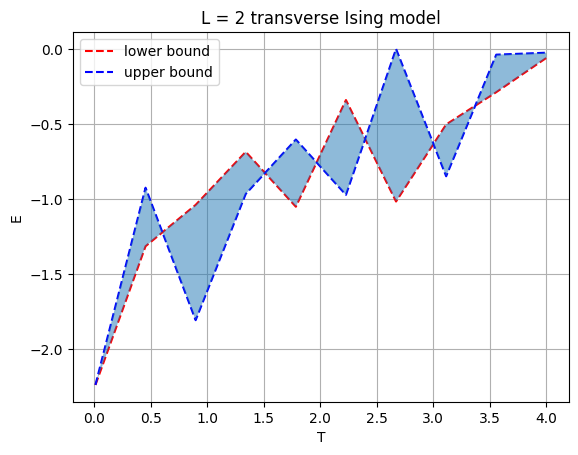

In [25]:
plt.fill_between(1/betas, mins, maxs, alpha = 0.5, zorder = 3)
plt.plot(1/betas, mins,c ='red',linestyle='--',label='lower bound', zorder = 2)
plt.plot(1/betas, maxs,c ='blue',linestyle='--',label='upper bound', zorder = 2)
plt.xlabel('T')
plt.ylabel('E')
plt.title(f'L = {L} transverse Ising model')
plt.legend()
plt.grid(zorder = 1)
plt.show()